In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.ndimage.filters import convolve1d
import os
import scipy.stats
from matplotlib.lines import Line2D

In [2]:
def read_files(path):
    contents = []
    for file in os.listdir(path):
        # if file_name in file:
        contents.append(pd.read_csv(os.path.join(path, file)))
    return contents

def sum_reward(data):
    sum_ = np.zeros(len(data))
    for column in data.columns:
        if 'reward' in column:
            sum_ = sum_ + data[column].values
    return sum_ * data['steps']
#     return sum_

def sum_collision(data):
    sum_ = np.zeros(len(data))
    for column in data.columns:
        if 'collision' in column:
            sum_ = sum_ + data[column].values
    return sum_ / data['steps']
    # return sum_

def get_rewards(path, window=1):
    rewards = read_files(path)
    sum_rewards = [sum_reward(r) for r in rewards]
    # 3 is the number of files
    sum_rewards = sum(sum_rewards) / len(rewards)
    return convolve1d(sum_rewards, np.ones(window) / window)

def get_collisions(path):
    # for reinforce
    rewards = read_files(path)
    collisions = [sum_collision(r) / 2 for r in rewards]
    return sum(collisions) / len(collisions)

def exploration(data):
    return data['exploration_0']

def get_exploration(path, window=1):
    rewards = read_files(path)
    key = 'exploration_0'
    sum_rewards = [r[key] / r['steps'] for r in rewards]
    sum_rewards = sum(sum_rewards)
    return convolve1d(sum_rewards, np.ones(window) / window)


def get_avg_reward(path, comm_probs, n_agents):
    mean, low ,up = [], [], []
    for comm_prob in comm_probs:
        rewards = read_files(path.format(comm_prob))
        sum_rewards = [sum_reward(r) / n_agents for r in rewards]
        rr = np.concatenate(sum_rewards)
        # sum_rewards = [sum_reward(r).mean() / n_agents for r in rewards]
        # sum_rewards = sum(sum_rewards)
        m, l, u = mean_confidence_interval(rr)
        mean.append(m)
        low.append(l)
        up.append(u)
    return np.asarray(mean), np.asarray(low), np.asarray(up)

def get_collisions(path):
    # for reinforce
    rewards = read_files(path)
    collisions = [sum_collision(r) / 2 for r in rewards]
    return sum(collisions)

def get_avg_collision(path, comm_probs, n_agents):
    mean, low ,up = [], [], []
    for comm_prob in comm_probs:
        rewards = read_files(path.format(comm_prob))
        sum_rewards = [sum_collision(r) / 2 for r in rewards]
        rr = np.concatenate(sum_rewards)
        # print(rr.shape)
        # sum_rewards = [sum_reward(r).mean() / n_agents for r in rewards]
        # sum_rewards = sum(sum_rewards)
        m, l, u = mean_confidence_interval(rr)
        mean.append(m)
        low.append(l)
        up.append(u)
    return np.asarray(mean), np.asarray(low), np.asarray(up)

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

def read_REINFORCE(path, n_agents):
    rewards = read_files(path)

# Rewards vs Epi

In [3]:
EPS_START=0.8
EPS_END = 0.05
EPS_DECAY = 10
EPS_END + (EPS_START - EPS_END) * np.exp(-1. * 10000 / EPS_DECAY)

0.05

FileNotFoundError: [WinError 3] 系统找不到指定的路径。: '.././results/personality_6agents_0comm/save'

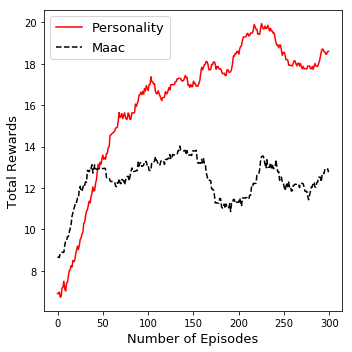

In [5]:
window = 50
for n_agents in [4, 6, 8]:
    maac_path = '../results/maac_{}agents_0comm/save'.format(n_agents)
    personality_path = '.././results/personality_{}agents_0comm/save'.format(n_agents)
    # fedhac_path = './results/FedHMARL_{}agents_0comm/save'.format(n_agents)
    # RE_path = './results/REINFORCE_{}agents/save'.format(n_agents)
    rewards_maac = get_rewards(maac_path, window)
    rewards_personality = get_rewards(personality_path, window)
    # rewards_fedhac = get_rewards(fedhac_path, window)
    # rewards_RE = get_rewards(RE_path, window)

    plt.figure(figsize=(5, 5))
    plt.plot(rewards_personality / n_agents, color='red', linestyle='-')
    # plt.plot(rewards_fedhac / n_agents, color='blue', linestyle='-.')
    plt.plot(rewards_maac / n_agents, color='black', linestyle='--')
    # plt.plot(rewards_RE / n_agents, color='green', linestyle='-.')
    plt.legend(['Personality', 'Maac', 'MAAC', 'REINFORCE'], fontsize=13)
    plt.xlabel('Number of Episodes', fontsize=13)
    plt.ylabel('Total Rewards', fontsize=13)
    plt.tight_layout()
#     plt.savefig("./results/figure/v2/rewards_vs_epi_{}agents.pdf".format(n_agents),
#                  quality=95, dpi=300, bbox_inches='tight')

    # explorations_maac = get_exploration(maac_path, window)
    # explorations_hac = get_exploration(hac_path, window)
    # explorations_RE = get_exploration(RE_path, window)
    #
    # plt.figure()
    # plt.plot(explorations_hac, color='red', linestyle='-')
    # plt.plot(explorations_maac, color='black', linestyle='--')
    # plt.plot(explorations_RE, color='blue', linestyle='-.')
    # plt.legend(['HMARL (ours)', 'MAAC', 'REINFORCE'], fontsize=13)
    # plt.xlabel('Number of Episodes', fontsize=13)
    # plt.ylabel('Exploration Area', fontsize=13)
    # plt.tight_layout()
    # plt.savefig("./results/figure/exploration_vs_epi_{}agents.pdf".format(n_agents),
    #             quality=95, dpi=300, bbox_inches='tight')

# Rewards vs communication prob

In [1028]:
def read_files(path):
    contents = []
    for file in os.listdir(path):
        # if file_name in file:
        contents.append(pd.read_csv(os.path.join(path, file)))
    return contents

def get_reward(path, n_agent):
    data = read_files(path)
    total_collisions = []
    for d in data:
#         d = d.iloc[-200:, :]
        d = d.drop(d[d['steps'] <= 3].index, axis=0)
        collisions = np.zeros(len(d))
        for c in d.columns:
            if 'reward' in c:
                collisions += d[c].values
            # only keep data that has a certain number of steps
        total_collisions.append(collisions * d['steps'])
#         total_collisions.append(collisions)
    result = np.concatenate(total_collisions)
    m, l, u = mean_confidence_interval(result)
    return m, l, u

def get_avg_reward(path, comm_probs, n_agent):
    ms, ls, us = [], [], []
    for prob in comm_probs:
        m, l, u = get_reward(path.format(prob), n_agent)
        ms.append(m)
        ls.append(l)
        us.append(u)
    return np.asarray(ms), np.asarray(ls), np.asarray(us)

In [1047]:
comm_probs = [0, 0.2, 0.4, 0.6, 0.8, 1]
m_maac2, l_maac2, u_maac2 = get_avg_reward("../results/maac_2agents_{}comm/save", comm_probs, 2)
m_maac4, l_maac4, u_maac4 = get_avg_reward("../results/maac_4agents_{}comm/save", comm_probs, 4)
m_maac6, l_maac6, u_maac6 = get_avg_reward("./results/maac_6agents_{}comm/save", comm_probs, 6)
m_maac8, l_maac8, u_maac8 = get_avg_reward("../results/maac_8agents_{}comm/save", comm_probs, 8)
m_maac10, l_maac10, u_maac10 = get_avg_reward("../results/maac_10agents_{}comm/save", comm_probs, 10)
m_hac2, l_hac2, u_hac2 = get_avg_reward("../results/hac_2agents_{}comm/save", comm_probs, 2)
m_hac4, l_hac4, u_hac4 = get_avg_reward("../results/hac_4agents_{}comm/save", comm_probs, 4)
m_hac6, l_hac6, u_hac6 = get_avg_reward("../results/hac_6agents_{}comm/save", comm_probs, 6)
m_hac8, l_hac8, u_hac8 = get_avg_reward("../results0/hac_8agents_{}comm/save", comm_probs, 8)
m_hac10, l_hac10, u_hac10 = get_avg_reward("../results/hac_10agents_{}comm/save", comm_probs, 10)
m_fedhac2, l_fedhac2, u_fedhac2 = get_avg_reward("./results/FedHMARL_2agents_{}comm/save", comm_probs, 2)
m_fedhac4, l_fedhac4, u_fedhac4 = get_avg_reward("./results/FedHMARL_4agents_{}comm/save", comm_probs, 4)
m_fedhac6, l_fedhac6, u_fedhac6 = get_avg_reward("./results/FedHMARL_6agents_{}comm/save", comm_probs, 6)
m_fedhac8, l_fedhac8, u_fedhac8 = get_avg_reward("./results/FedHMARL_8agents_{}comm/save", comm_probs, 8)
m_fedhac10, l_fedhac10, u_fedhac10 = get_avg_reward("./results/FedHMARL_10agents_{}comm/save", comm_probs, 10)
m_RE2, l_RE2, u_RE2 = get_avg_reward("../results/REINFORCE_2agents_0comm/save", [0], 2)
m_RE4, l_RE4, u_RE4 = get_avg_reward("../results/REINFORCE_4agents/save", [0], 4)
m_RE6, l_RE6, u_RE6 = get_avg_reward("../results/REINFORCE_6agents/save", [0], 6)
m_RE8, l_RE8, u_RE8 = get_avg_reward("../results/REINFORCE_8agents/save", [0], 8)
m_RE10, l_RE10, u_RE10 = get_avg_reward("../results/REINFORCE_10agents_0comm/save", [0], 10)
# m_RE2 = get_rewards('./results/REINFORCE_2agents/save')
# m_RE2 = m_RE2.mean() / 2
# m_RE4 = get_rewards('./results/REINFORCE_4agents/save')
# m_RE4 = m_RE4.mean() / 4
# m_RE6 = get_rewards('./results/REINFORCE_6agents/save')
# m_RE6 = m_RE6.mean() / 6
# m_RE8 = get_rewards('./results/REINFORCE_8agents/save')
# m_RE8 = m_RE8.mean() / 8
# m_RE10 = get_rewards('./results/REINFORCE_10agents_0comm/save')
# m_RE10 = m_RE10.mean() / 10


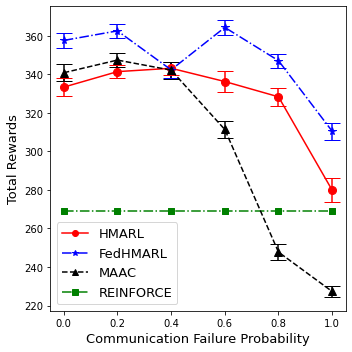

In [1037]:
#exchange maac and hac!
#they are in opposite folders
# now they are ok!

# plt.plot(comm_probs, m_hac4)
# plt.plot(comm_probs, m_maac4)
plt.figure(figsize=(5, 5))
plt.errorbar(comm_probs, m_hac4, u_hac4 - m_hac4, color='red', capsize=8,
             linestyle='-', marker='o', markersize=8)
plt.errorbar(comm_probs, m_fedhac4, u_fedhac4 - m_fedhac4, color='blue', capsize=8,
             linestyle='-.', marker='*', markersize=8)
plt.errorbar(comm_probs, m_maac4, u_maac4 - m_maac4, color='black', capsize=8,
             linestyle='--', marker='^', markersize=8)
plt.hlines(m_RE4, 0, 1, color='green', linestyle='-.')
plt.scatter(comm_probs, m_RE4 * np.ones_like(comm_probs), marker='s', color='green')
legend_elements = [Line2D([0], [0], color='red', linestyle='-', marker='o', label='HMARL'),
                   Line2D([0], [0], color='blue', linestyle='-.', marker='*', label='FedHMARL'),
                   Line2D([0], [0], color='black', linestyle='--', marker='^', label='MAAC'),
                   Line2D([0], [0], color='green', linestyle='-.', marker='s', label='REINFORCE')]
plt.legend(handles=legend_elements, fontsize=13)
plt.xlabel('Communication Failure Probability', fontsize=13)
plt.ylabel('Total Rewards', fontsize=13)
plt.tight_layout()
plt.savefig("./results/figure/v2/rewards_vs_comm_probs_4agents.pdf", quality=95, dpi=300, bbox_inches='tight')

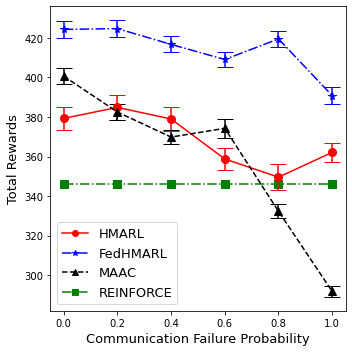

In [1048]:
plt.figure(figsize=(5, 5))

# plt.plot(comm_probs, m_hac6)
# plt.plot(comm_probs, m_maac6)

plt.errorbar(comm_probs, m_hac6, u_hac6 - m_hac6, color='red', capsize=8,
             linestyle='-', marker='o', markersize=8)
plt.errorbar(comm_probs, m_fedhac6, u_fedhac6 - m_fedhac6, color='blue', capsize=8,
             linestyle='-.', marker='*', markersize=8)
plt.errorbar(comm_probs, m_maac6, u_maac6 - m_maac6, color='black', capsize=8,
             linestyle='--', marker='^', markersize=8)
plt.hlines(m_RE6, 0, 1, color='green', linestyle='-.')
plt.scatter(comm_probs, m_RE6 * np.ones_like(comm_probs), marker='s', color='green', s=60)
legend_elements = [Line2D([0], [0], color='red', linestyle='-', marker='o', label='HMARL'),
                   Line2D([0], [0], color='blue', linestyle='-.', marker='*', label='FedHMARL'),
                   Line2D([0], [0], color='black', linestyle='--', marker='^', label='MAAC'),
                   Line2D([0], [0], color='green', linestyle='-.', marker='s', label='REINFORCE')]
plt.legend(handles=legend_elements, fontsize=13)
plt.xlabel('Communication Failure Probability', fontsize=13)
plt.ylabel('Total Rewards', fontsize=13)
plt.tight_layout()
plt.savefig("./results/figure/v2/rewards_vs_comm_probs_6agents.pdf", quality=95, dpi=300, bbox_inches='tight')

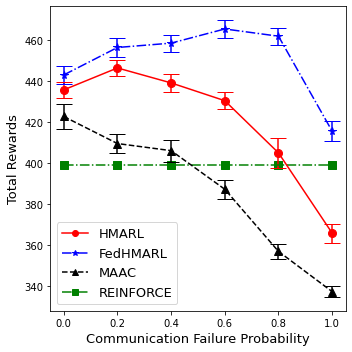

In [1051]:
plt.figure(figsize=(5, 5))

plt.errorbar(comm_probs, m_hac8, u_hac8 - m_hac8, color='red', capsize=8,
             linestyle='-', marker='o', markersize=8)
plt.errorbar(comm_probs, m_fedhac8, u_fedhac8 - m_fedhac8, color='blue', capsize=8,
             linestyle='-.', marker='*', markersize=8)
plt.errorbar(comm_probs, m_maac8, u_maac8 - m_maac8, color='black', capsize=8,
             linestyle='--', marker='^', markersize=8)
plt.hlines(m_RE8, 0, 1, color='green', linestyle='-.')
plt.scatter(comm_probs, m_RE8 * np.ones_like(comm_probs), marker='s', color='green', s=60)
legend_elements = [Line2D([0], [0], color='red', linestyle='-', marker='o', label='HMARL'),
                   Line2D([0], [0], color='blue', linestyle='-.', marker='*', label='FedHMARL'),
                   Line2D([0], [0], color='black', linestyle='--', marker='^', label='MAAC'),
                   Line2D([0], [0], color='green', linestyle='-.', marker='s', label='REINFORCE')]
plt.legend(handles=legend_elements, fontsize=13)
plt.xlabel('Communication Failure Probability', fontsize=13)
plt.ylabel('Total Rewards', fontsize=13)
plt.tight_layout()
plt.savefig("./results/figure/v2/rewards_vs_comm_probs_8agents.pdf", quality=95, dpi=300, bbox_inches='tight')

# Rewards vs Number of agents

In [669]:
m_hac_comm0 = np.asarray([m_hac2[0], m_hac4[0], m_hac6[0], m_hac8[0], m_hac10[0]])
m_hac_comm04 = np.asarray([m_hac2[3], m_hac4[3], m_hac6[3], m_hac8[3], m_hac10[3]])
m_hac_comm08 = np.asarray([m_hac2[4], m_hac4[4], m_hac6[4], m_hac8[4], m_hac10[4]])
u_hac_comm0 = np.asarray([u_hac2[0], u_hac4[0], u_hac6[0], u_hac8[0], u_hac10[0]])
u_hac_comm04 = np.asarray([u_hac2[3], u_hac4[3], u_hac6[3], u_hac8[3], u_hac10[3]])
u_hac_comm08 = np.asarray([u_hac2[4], u_hac4[4], u_hac6[4], u_hac8[4], u_hac10[4]])

m_fedhac_comm0 = np.asarray([m_fedhac2[0], m_fedhac4[0], m_fedhac6[0], m_fedhac8[0], m_fedhac10[0]])
m_fedhac_comm04 = np.asarray([m_fedhac2[3], m_fedhac4[3], m_fedhac6[3], m_fedhac8[3], m_fedhac10[3]])
m_fedhac_comm08 = np.asarray([m_fedhac2[4], m_fedhac4[4], m_fedhac6[4], m_fedhac8[4], m_fedhac10[4]])
u_fedhac_comm0 = np.asarray([u_fedhac2[0], u_fedhac4[0], u_fedhac6[0], u_fedhac8[0], u_fedhac10[0]])
u_fedhac_comm04 = np.asarray([u_fedhac2[3], u_fedhac4[3], u_fedhac6[3], u_fedhac8[3], u_fedhac10[3]])
u_fedhac_comm08 = np.asarray([u_fedhac2[4], u_fedhac4[4], u_fedhac6[4], u_fedhac8[4], u_fedhac10[4]])

m_maac_comm0 = np.asarray([m_maac2[0], m_maac4[0], m_maac6[0], m_maac8[0], m_maac10[0]])
m_maac_comm04 = np.asarray([m_maac2[3], m_maac4[3], m_maac6[3], m_maac8[3], m_maac10[3]])
m_maac_comm08 = np.asarray([m_maac2[4], m_maac4[4], m_maac6[4], m_maac8[4], m_maac10[4]])
u_maac_comm0 = np.asarray([u_maac2[0], u_maac4[0], u_maac6[0], u_maac8[0], u_maac10[0]])
u_maac_comm04 = np.asarray([u_maac2[3], u_maac4[3], u_maac6[3], u_maac8[3], u_maac10[3]])
u_maac_comm08 = np.asarray([u_maac2[4], u_maac4[4], u_maac6[4], u_maac8[4], u_maac10[4]])

m_RE_comm0 = np.asarray([m_RE2, m_RE4, m_RE6, m_RE8, m_RE10])
u_RE_comm0 = np.asarray([u_RE2, u_RE4, u_RE6, u_RE8, u_RE10])

C:\Users\vsadhu\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  del sys.path[0]


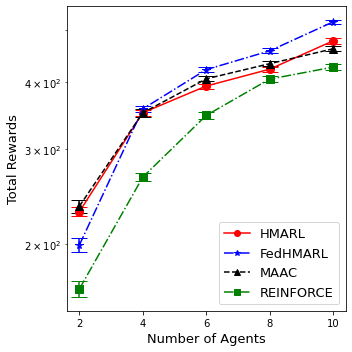

In [676]:
plt.figure(figsize=(5, 5))

n_agents = [2, 4, 6, 8, 10]
plt.errorbar(n_agents, m_hac_comm0, u_hac_comm0 - m_hac_comm0, color='red', capsize=8,
             linestyle='-', marker='o', markersize=8)
plt.errorbar(n_agents, m_fedhac_comm0, u_fedhac_comm0 - m_fedhac_comm0, color='blue', capsize=8,
             linestyle='-.', marker='*', markersize=8)
plt.errorbar(n_agents, m_maac_comm0, u_maac_comm0 - m_maac_comm0, color='black', capsize=8,
             linestyle='--', marker='^', markersize=8)
# plt.hlines(m_RE_comm0, 0, 1, color='blue', linestyle='-.')
# plt.scatter(n_agents, m_RE_comm0 * np.ones_like(comm_probs), marker='s', color='blue', s=60)
plt.errorbar(n_agents, m_RE_comm0, u_RE_comm0 - m_RE_comm0, color='green', capsize=8,
             linestyle='-.', marker='s', markersize=8)
legend_elements = [Line2D([0], [0], color='red', linestyle='-', marker='o', label='HMARL'),
                   Line2D([0], [0], color='blue', linestyle='-.', marker='*', label='FedHMARL'),
                   Line2D([0], [0], color='black', linestyle='--', marker='^', label='MAAC'),
                   Line2D([0], [0], color='green', linestyle='-.', marker='s', label='REINFORCE')]
plt.xticks(n_agents, n_agents)
plt.legend(handles=legend_elements, fontsize=13)
plt.xlabel('Number of Agents', fontsize=13)
plt.ylabel('Total Rewards', fontsize=13)
plt.tight_layout()
# plt.savefig("./results/figure/v2/rewards_vs_n_agents_comm0.pdf", quality=95, dpi=300, bbox_inches='tight')

C:\Users\vsadhu\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  # This is added back by InteractiveShellApp.init_path()


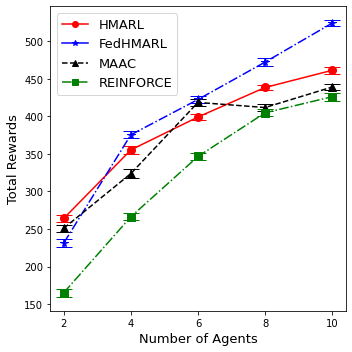

In [674]:
plt.figure(figsize=(5, 5))

n_agents = [2, 4, 6, 8, 10]
plt.errorbar(n_agents, m_hac_comm04, u_hac_comm04 - m_hac_comm04, color='red', capsize=8,
             linestyle='-', marker='o', markersize=8)
plt.errorbar(n_agents, m_fedhac_comm04, u_fedhac_comm04 - m_fedhac_comm04, color='blue', capsize=8,
             linestyle='-.', marker='*', markersize=8)
plt.errorbar(n_agents, m_maac_comm04, u_maac_comm04 - m_maac_comm04, color='black', capsize=8,
             linestyle='--', marker='^', markersize=8)
plt.errorbar(n_agents, m_RE_comm0, u_RE_comm0 - m_RE_comm0, color='green', capsize=8,
             linestyle='-.', marker='s', markersize=8)
legend_elements = [Line2D([0], [0], color='red', linestyle='-', marker='o', label='HMARL'),
                   Line2D([0], [0], color='blue', linestyle='-', marker='*', label='FedHMARL'),
                   Line2D([0], [0], color='black', linestyle='--', marker='^', label='MAAC'),
                   Line2D([0], [0], color='green', linestyle='-.', marker='s', label='REINFORCE')]
plt.xticks(n_agents, n_agents)

plt.legend(handles=legend_elements, fontsize=13)
plt.xlabel('Number of Agents', fontsize=13)
plt.ylabel('Total Rewards', fontsize=13)
plt.tight_layout()
plt.savefig("./results/figure/v2/rewards_vs_n_agents_comm04.pdf", quality=95, dpi=300, bbox_inches='tight')

C:\Users\vsadhu\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  del sys.path[0]


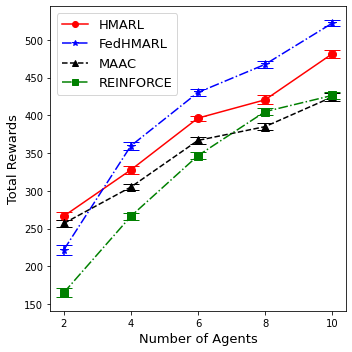

In [675]:
plt.figure(figsize=(5, 5))

n_agents = [2, 4, 6, 8, 10]
plt.errorbar(n_agents, m_hac_comm08, u_hac_comm08 - m_hac_comm08, color='red', capsize=8,
             linestyle='-', marker='o', markersize=8)
plt.errorbar(n_agents, m_fedhac_comm08, u_fedhac_comm08 - m_fedhac_comm08, color='blue', capsize=8,
             linestyle='-.', marker='*', markersize=8)
plt.errorbar(n_agents, m_maac_comm08, u_maac_comm08 - m_maac_comm08, color='black', capsize=8,
             linestyle='--', marker='^', markersize=8)
# plt.hlines(m_RE_comm0, 0, 1, color='blue', linestyle='-.')
# plt.scatter(n_agents, m_RE_comm0 * np.ones_like(comm_probs), marker='s', color='blue', s=60)
plt.errorbar(n_agents, m_RE_comm0, u_RE_comm0 - m_RE_comm0, color='green', capsize=8,
             linestyle='-.', marker='s', markersize=8)
legend_elements = [Line2D([0], [0], color='red', linestyle='-', marker='o', label='HMARL'),
                   Line2D([0], [0], color='blue', linestyle='-.', marker='*', label='FedHMARL'),
                   Line2D([0], [0], color='black', linestyle='--', marker='^', label='MAAC'),
                   Line2D([0], [0], color='green', linestyle='-.', marker='s', label='REINFORCE')]
plt.xticks(n_agents, n_agents)

plt.legend(handles=legend_elements, fontsize=13)
plt.xlabel('Number of Agents', fontsize=13)
plt.ylabel('Total Rewards', fontsize=13)
plt.tight_layout()
plt.savefig("./results/figure/v2/rewards_vs_n_agents_comm08.pdf", quality=95, dpi=300, bbox_inches='tight')

# Collisions vs Communication Prob

In [1011]:
def read_files(path):
    contents = []
    for file in os.listdir(path):
        # if file_name in file:
        contents.append(pd.read_csv(os.path.join(path, file)))
    return contents

def get_collision(path, n_agent):
    data = read_files(path)
    total_collisions = []
    for d in data:
#         d = d.iloc[200:, :]
        d = d.drop(d[d['steps'] <= 5].index, axis=0)
        collisions = np.zeros(len(d))
        for c in d.columns:
            if 'collision' in c:
                collisions += d[c].values
            # only keep data that has a certain number of steps
        total_collisions.append(collisions / d['steps'])
#         total_collisions.append(collisions)
    result = np.concatenate(total_collisions) / n_agent
    m, l, u = mean_confidence_interval(result)
    return m, l, u

def get_avg_collision(path, comm_probs, n_agent):
    ms, ls, us = [], [], []
    for prob in comm_probs:
        m, l, u = get_collision(path.format(prob), n_agent)
        ms.append(m)
        ls.append(l)
        us.append(u)
    return np.asarray(ms), np.asarray(ls), np.asarray(us)


In [1024]:
comm_probs = [0, 0.2, 0.4, 0.6, 0.8, 1]
m_maac4, l_maac4, u_maac4 = get_avg_collision("./results/maac_4agents_{}comm/save", comm_probs, 4)
m_maac6, l_maac6, u_maac6 = get_avg_collision("./results/maac_6agents_{}comm/save", comm_probs, 6)
m_maac8, l_maac8, u_maac8 = get_avg_collision("./results/maac_8agents_{}comm/save", comm_probs, 8)
m_maac10, l_maac10, u_maac10 = get_avg_collision("./results/maac_10agents_{}comm/save", comm_probs, 10)
m_hac4, l_hac4, u_hac4 = get_avg_collision("./results/hac_4agents_{}comm/save", comm_probs, 4)
m_hac6, l_hac6, u_hac6 = get_avg_collision("./results/hac_6agents_{}comm/save", comm_probs, 6)
m_hac8, l_hac8, u_hac8 = get_avg_collision("./results/hac_8agents_{}comm/save", comm_probs, 8)
m_hac10, l_hac10, u_hac10 = get_avg_collision("./results/hac_10agents_{}comm/save", comm_probs, 10)
m_fedhac4, l_fedhac4, u_fedhac4 = get_avg_collision("./results/FedHMARL_4agents_{}comm/save", comm_probs, 4)
m_fedhac6, l_fedhac6, u_fedhac6 = get_avg_collision("./results/FedHMARL_6agents_{}comm/save", comm_probs, 6)
m_fedhac8, l_fedhac8, u_fedhac8 = get_avg_collision("./results/FedHMARL_8agents_{}comm/save", comm_probs, 8)
m_fedhac10, l_fedhac10, u_fedhac10 = get_avg_collision("./results/FedHMARL_10agents_{}comm/save", comm_probs, 10)
# m_RE4, l_RE4, u_RE4 = get_avg_collision("./results/REINFORCE_4agents_0comm/save", [0], 4)
# m_RE6, l_RE6, u_RE6 = get_avg_collision("./results/REINFORCE_6agents_0comm/save", [0], 6)
# m_RE8, l_RE8, u_RE8 = get_avg_collision("./results/REINFORCE_8agents_0comm/save", [0], 8)

# m_RE4 = get_collisions("./results/REINFORCE_4agents_0comm/save").mean()
# m_RE6 = get_collisions("./results/REINFORCE_6agents_0comm/save").mean()
# m_RE8 = get_collisions("./results/REINFORCE_8agents_0comm/save").mean()

# m_maac4, l_maac4, u_maac4 = get_avg_collision("./results/maac_4agents_{}comm/save", comm_probs)
# m_maac6, l_maac6, u_maac6 = get_avg_collision("./results/maac_6agents_{}comm/save", comm_probs)
# m_maac8, l_maac8, u_maac8 = get_avg_collision("./results/maac_8agents_{}comm/save", comm_probs)
# m_hac4, l_hac4, u_hac4 = get_avg_collision("./results/hac_4agents_{}comm/save", comm_probs)
# m_hac6, l_hac6, u_hac6 = get_avg_collision("./results/hac_6agents_{}comm/save", comm_probs)
# m_hac8, l_hac8, u_hac8 = get_avg_collision("./results/hac_8agents_{}comm/save", comm_probs)
# m_fedhac4, l_fedhac4, u_fedhac4 = get_avg_collision("./results/FedHMARL_4agents_{}comm/save", comm_probs)
# m_fedhac6, l_fedhac6, u_fedhac6 = get_avg_collision("./results/FedHMARL_6agents_{}comm/save", comm_probs)
# m_fedhac8, l_fedhac8, u_fedhac8 = get_avg_collision("./results/FedHMARL_8agents_{}comm/save", comm_probs)
m_RE4, l_RE4, u_RE4 = get_avg_collision("./results/REINFORCE_4agents_0comm/save", [0], 4)
m_RE6, l_RE6, u_RE6 = get_avg_collision("./results/REINFORCE_6agents_0comm/save", [0], 6)
m_RE8, l_RE8, u_RE8 = get_avg_collision("./results/REINFORCE_8agents_0comm/save", [0], 8)
m_RE10, l_RE10, u_RE10 = get_avg_collision("./results/REINFORCE_10agents_0comm/save", [0], 10)

# m_RE4, _, _ = get_avg_collision("./results/REINFORCE_4agents_0comm/save", [0])
# m_RE6, _, _ = get_avg_collision("./results/REINFORCE_6agents_0comm/save", [0])
# m_RE8, _, _ = get_avg_collision("./results/REINFORCE_8agents_0comm/save", [0])

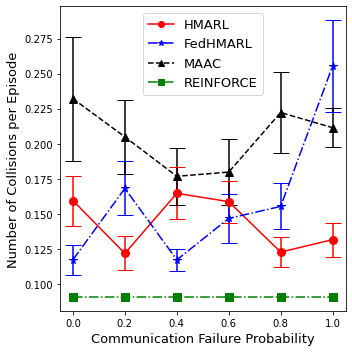

In [1025]:
plt.figure(figsize=(5, 5))

plt.errorbar(comm_probs, m_hac6, u_hac6 - m_hac6, color='red', capsize=8,
             linestyle='-', marker='o', markersize=8)
plt.errorbar(comm_probs, m_fedhac6, u_fedhac6 - m_fedhac6, color='blue', capsize=8,
             linestyle='-.', marker='*', markersize=8)
plt.errorbar(comm_probs, m_maac6, u_maac6 - m_maac6, color='black', capsize=8,
             linestyle='--', marker='^', markersize=8)
plt.hlines(m_RE6, 0, 1, color='green', linestyle='-.')
plt.scatter(comm_probs, m_RE6 * np.ones_like(comm_probs), marker='s', color='green', s=60)
legend_elements = [Line2D([0], [0], color='red', linestyle='-', marker='o', label='HMARL'),
                   Line2D([0], [0], color='blue', linestyle='-.', marker='*', label='FedHMARL'),
                   Line2D([0], [0], color='black', linestyle='--', marker='^', label='MAAC'),
                   Line2D([0], [0], color='green', linestyle='-.', marker='s', label='REINFORCE')]
plt.legend(handles=legend_elements, fontsize=13)
plt.xlabel('Communication Failure Probability', fontsize=13)
plt.ylabel('Number of Collisions per Episode', fontsize=13)
plt.tight_layout()
# plt.savefig("./results/figure/v2/collisions_vs_comm_probs_6agents.pdf", quality=95, dpi=300, bbox_inches='tight')


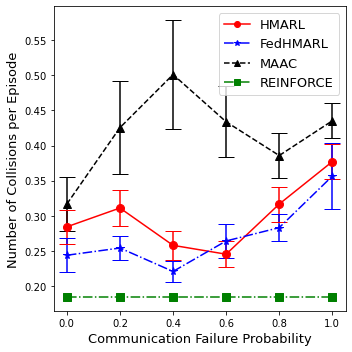

In [1026]:
plt.figure(figsize=(5, 5))

plt.errorbar(comm_probs, m_hac8, u_hac8 - m_hac8, color='red', capsize=8,
             linestyle='-', marker='o', markersize=8)
plt.errorbar(comm_probs, m_fedhac8, u_fedhac8 - m_fedhac8, color='blue', capsize=8,
             linestyle='-.', marker='*', markersize=8)
plt.errorbar(comm_probs, m_maac8, u_maac8 - m_maac8, color='black', capsize=8,
             linestyle='--', marker='^', markersize=8)
plt.hlines(m_RE8, 0, 1, color='green', linestyle='-.')
plt.scatter(comm_probs, m_RE8 * np.ones_like(comm_probs), marker='s', color='green', s=60)
legend_elements = [Line2D([0], [0], color='red', linestyle='-', marker='o', label='HMARL'),
                   Line2D([0], [0], color='blue', linestyle='-.', marker='*', label='FedHMARL'),
                   Line2D([0], [0], color='black', linestyle='--', marker='^', label='MAAC'),
                   Line2D([0], [0], color='green', linestyle='-.', marker='s', label='REINFORCE')]
plt.legend(handles=legend_elements, fontsize=13)
plt.xlabel('Communication Failure Probability', fontsize=13)
plt.ylabel('Number of Collisions per Episode', fontsize=13)
plt.tight_layout()
# plt.savefig("./results/figure/v2/collisions_vs_comm_probs_8agents.pdf", quality=95, dpi=300, bbox_inches='tight')

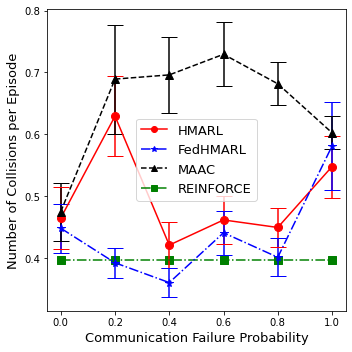

In [1027]:
plt.figure(figsize=(5, 5))
plt.errorbar(comm_probs, m_hac10, u_hac10 - m_hac10, color='red', capsize=8,
             linestyle='-', marker='o', markersize=8)
plt.errorbar(comm_probs, m_fedhac10, u_fedhac10 - m_fedhac10, color='blue', capsize=8,
             linestyle='-.', marker='*', markersize=8)
plt.errorbar(comm_probs, m_maac10, u_maac10 - m_maac10, color='black', capsize=8,
             linestyle='--', marker='^', markersize=8)
plt.hlines(m_RE10, 0, 1, color='green', linestyle='-.')
plt.scatter(comm_probs, m_RE10 * np.ones_like(comm_probs), marker='s', color='green', s=60)
legend_elements = [Line2D([0], [0], color='red', linestyle='-', marker='o', label='HMARL'),
                   Line2D([0], [0], color='blue', linestyle='-.', marker='*', label='FedHMARL'),
                   Line2D([0], [0], color='black', linestyle='--', marker='^', label='MAAC'),
                   Line2D([0], [0], color='green', linestyle='-.', marker='s', label='REINFORCE')]
plt.legend(handles=legend_elements, fontsize=13)
plt.xlabel('Communication Failure Probability', fontsize=13)
plt.ylabel('Number of Collisions per Episode', fontsize=13)
plt.tight_layout()
# plt.savefig("./results/figure/v2/collisions_vs_comm_probs_10agents.pdf", quality=95, dpi=300, bbox_inches='tight')

# New Scenario


In [790]:
def get_avg_targets(path, comm_probs, n_agents):
    mean, low ,up = [], [], []
    for comm_prob in comm_probs:
        rewards = read_files(path.format(comm_prob))
        sum_rewards = [sum_targets(r) / n_agents for r in rewards]
        rr = np.concatenate(sum_rewards)
        # print(rr.shape)
        # sum_rewards = [sum_reward(r).mean() / n_agents for r in rewards]
        # sum_rewards = sum(sum_rewards)
        m, l, u = mean_confidence_interval(rr)
        mean.append(m)
        low.append(l)
        up.append(u)
    return np.asarray(mean), np.asarray(low), np.asarray(up)

def sum_targets(data):
    sum_ = np.zeros(len(data))
    for column in data.columns:
        if 'reward' in column:
            sum_ = sum_ + data[column].values
    return sum_ / data['steps']
#     return sum_

def read_files(path):
    contents = []
    for file in os.listdir(path):
        # if file_name in file:
        contents.append(pd.read_csv(os.path.join(path, file)))
    return contents

def get_reward(path, n_agent):
    data = read_files(path)
    total_collisions = []
    for d in data:
#         d = d.iloc[-200:, :]
        d = d.drop(d[d['steps'] <= 5].index, axis=0)
        collisions = np.zeros(len(d))
        for c in d.columns:
            if 'reward' in c:
                collisions += d[c].values
#             only keep data that has a certain number of steps
        total_collisions.append(collisions * d['steps'])
#         total_collisions.append(collisions)
    result = np.concatenate(total_collisions)
    m, l, u = mean_confidence_interval(result)
    return m, l, u

def get_avg_reward(path, comm_probs, n_agent):
    ms, ls, us = [], [], []
    for prob in comm_probs:
        m, l, u = get_reward(path.format(prob), n_agent)
        ms.append(m)
        ls.append(l)
        us.append(u)
    return np.asarray(ms), np.asarray(ls), np.asarray(us)

comm_probs = [0, 0.2, 0.4, 0.6, 0.8, 1]
m_maac2, l_maac2, u_maac2 = get_avg_reward("./results/maac_v2_2agents_{}comm/save", [0.4], 2)
m_maac4, l_maac4, u_maac4 = get_avg_reward("./results/maac_v2_4agents_{}comm/save", [0.4], 4)
m_maac6, l_maac6, u_maac6 = get_avg_reward("./results/maac_v2_6agents_{}comm/save", [0.4], 6)
m_maac8, l_maac8, u_maac8 = get_avg_reward("./results/maac_v2_8agents_{}comm/save", [0.4], 8)
m_maac10, l_maac10, u_maac10 = get_avg_reward("./results/maac_v2_10agents_{}comm/save", [0.4], 10)
m_maac12, l_maac12, u_maac12 = get_avg_reward("./results/maac_v2_12agents_{}comm/save", [0.4], 12)
m_maac14, l_maac14, u_maac14 = get_avg_reward("./results/maac_v2_14agents_{}comm/save", [0.4], 14)
m_hac2, l_hac2, u_hac2 = get_avg_reward("./results/hac_v2_2agents_{}comm/save", [0], 2)
m_hac4, l_hac4, u_hac4 = get_avg_reward("./results/hac_v2_4agents_{}comm/save", [0], 4)
m_hac6, l_hac6, u_hac6 = get_avg_reward("./results/hac_v2_6agents_{}comm/save", [0], 6)
m_hac8, l_hac8, u_hac8 = get_avg_reward("./results/hac_v2_8agents_{}comm/save", [0], 8)
m_hac10, l_hac10, u_hac10 = get_avg_reward("./results/hac_v2_10agents_{}comm/save", [0], 10)
m_hac12, l_hac12, u_hac12 = get_avg_reward("./results/hac_v2_12agents_{}comm/save", [0], 12)
m_hac14, l_hac14, u_hac14 = get_avg_reward("./results/hac_v2_14agents_{}comm/save", [0], 14)
m_fedhac2, l_fedhac2, u_fedhac2 = get_avg_reward("./results/FedHMARL_v2_2agents_0.4comm/save", [0], 2)
m_fedhac4, l_fedhac4, u_fedhac4 = get_avg_reward("./results/FedHMARL_v2_4agents_0.4comm/save", [0], 4)
m_fedhac6, l_fedhac6, u_fedhac6 = get_avg_reward("./results/FedHMARL_v2_6agents_0.4comm/save", [0], 6)
m_fedhac8, l_fedhac8, u_fedhac8 = get_avg_reward("./results/FedHMARL_v2_8agents_0.4comm/save", [0], 8)
m_fedhac10, l_fedhac10, u_fedhac10 = get_avg_reward("./results/FedHMARL_v2_10agents_0.4comm/save", [0], 10)
m_fedhac12, l_fedhac12, u_fedhac12 = get_avg_reward("./results/FedHMARL_v2_12agents_0.4comm/save", [0], 12)
m_fedhac14, l_fedhac14, u_fedhac14 = get_avg_reward("./results/FedHMARL_v2_14agents_0.4comm/save", [0], 14)
m_RE2, l_RE2, u_RE2 = get_avg_reward("../results/REINFORCE_2agents_0comm/save", [0], 2)
m_RE4, l_RE4, u_RE4 = get_avg_reward("../results/REINFORCE_4agents_0comm/save", [0], 4)
m_RE6, l_RE6, u_RE6 = get_avg_reward("../results/REINFORCE_6agents_0comm/save", [0], 6)
m_RE8, l_RE8, u_RE8 = get_avg_reward("../results/REINFORCE_8agents_0comm/save", [0], 8)
m_RE10, l_RE10, u_RE10 = get_avg_reward("../results/REINFORCE_10agents_0comm/save", [0], 10)
m_RE12, l_RE12, u_RE12 = get_avg_reward("../results/REINFORCE_v2_12agents_0comm/save", [0], 12)
m_RE14, l_RE14, u_RE14 = get_avg_reward("../results/REINFORCE_v2_14agents_0comm/save", [0], 14)

C:\Users\vsadhu\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  del sys.path[0]
C:\Users\vsadhu\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  from ipykernel import kernelapp as app
C:\Users\vsadhu\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
C:\Users\vsadhu\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotli

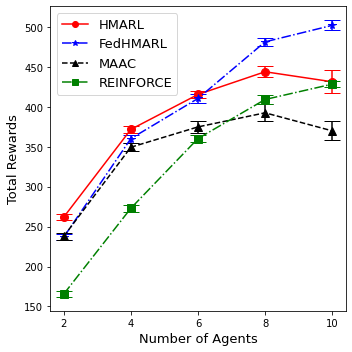

In [792]:
plt.figure(figsize=(5, 5))
n_agents = [2, 4, 6, 8, 10]
means_hac = np.asarray([m_hac2, m_hac4, m_hac6, m_hac8, m_hac10])
ups_hac = np.asarray([u_hac2, u_hac4, u_hac6, u_hac8, u_hac10])
means_fedhac = np.asarray([m_fedhac2, m_fedhac4, m_fedhac6, m_fedhac8, m_fedhac10])
ups_fedhac = np.asarray([u_fedhac2, u_fedhac4, u_fedhac6, u_fedhac8, u_fedhac10])
means_maac = np.asarray([m_maac2, m_maac4, m_maac6, m_maac8, m_maac10])
ups_maac = np.asarray([u_maac2, u_maac4, u_maac6, u_maac8, u_maac10])
means_RE = np.asarray([m_RE2, m_RE4, m_RE6, m_RE8, m_RE10])
ups_RE = np.asarray([u_RE2, u_RE4, u_RE6, u_RE8, u_RE10])

plt.errorbar(n_agents, means_hac, ups_hac - means_hac, color='red', capsize=8,
             linestyle='-', marker='o', markersize=8)
plt.errorbar(n_agents, means_fedhac, ups_fedhac - means_fedhac, color='blue', capsize=8,
             linestyle='-.', marker='*', markersize=8)
plt.errorbar(n_agents, means_maac, ups_maac - means_maac, color='black', capsize=8,
             linestyle='--', marker='^', markersize=8)
plt.errorbar(n_agents, means_RE, ups_RE - means_RE, color='green', capsize=8,
             linestyle='-.', marker='s', markersize=8)
# plt.legend(['MAAC', 'HAC', 'REINFORCE'])

legend_elements = [Line2D([0], [0], color='red', linestyle='-', marker='o', label='HMARL'),
                   Line2D([0], [0], color='blue', linestyle='-.', marker='*', label='FedHMARL'),
                   Line2D([0], [0], color='black', linestyle='--', marker='^', label='MAAC'),
                   Line2D([0], [0], color='green', linestyle='-.', marker='s', label='REINFORCE')]
plt.legend(handles=legend_elements, fontsize=13)
plt.xlabel('Number of Agents', fontsize=13)
plt.ylabel('Total Rewards', fontsize=13)
plt.xticks(n_agents, n_agents)
plt.tight_layout()
plt.savefig("./results/figure/v2/rewards_vs_n_agents_v2.pdf", quality=95, dpi=300, bbox_inches='tight')


In [796]:
def read_files(path):
    contents = []
    for file in os.listdir(path):
        # if file_name in file:
        contents.append(pd.read_csv(os.path.join(path, file)))
    return contents

def get_collision(path, n_agents):
    data = read_files(path)
    total_collisions = []
    for d in data:
#         d = d.iloc[-50:, :]
        d = d.drop(d[d['steps'] <= 5].index, axis=0)
        collisions = np.zeros(len(d))
        for c in d.columns:
            if 'collision' in c:
                collisions += d[c].values
            # only keep data that has a certain number of steps
        total_collisions.append(collisions / d['steps'])
#         total_collisions.append(collisions)
    result = np.concatenate(total_collisions) / n_agents
    m, l, u = mean_confidence_interval(result)
    return m, l, u

def get_avg_collision(path, comm_probs, n_agents):
    ms, ls, us = [], [], []
    for prob in comm_probs:
        m, l, u = get_collision(path.format(prob), n_agents)
        ms.append(m)
        ls.append(l)
        us.append(u)
    return np.asarray(ms), np.asarray(ls), np.asarray(us)

In [797]:
comm_probs = [0, 0.2, 0.4, 0.6, 0.8, 1]
m_maac2, l_maac2, u_maac2 = get_avg_collision("./results/maac_v2_2agents_{}comm/save", [0.4], 2)
m_maac4, l_maac4, u_maac4 = get_avg_collision("./results/maac_v2_4agents_{}comm/save", [0.4], 4)
m_maac6, l_maac6, u_maac6 = get_avg_collision("./results/maac_v2_6agents_{}comm/save", [0.4], 6)
m_maac8, l_maac8, u_maac8 = get_avg_collision("./results/maac_v2_8agents_{}comm/save", [0.4], 8)
m_maac10, l_maac10, u_maac10 = get_avg_collision("./results/maac_v2_10agents_{}comm/save", [0.4], 10)
m_maac12, l_maac12, u_maac12 = get_avg_collision("./results/maac_v2_12agents_{}comm/save", [0.4], 12)
m_maac14, l_maac14, u_maac14 = get_avg_collision("./results/maac_v2_14agents_{}comm/save", [0.4], 14)
m_hac2, l_hac2, u_hac2 = get_avg_collision("./results/hac_v2_2agents_{}comm/save", [0], 2)
m_hac4, l_hac4, u_hac4 = get_avg_collision("./results/hac_v2_4agents_{}comm/save", [0], 4)
m_hac6, l_hac6, u_hac6 = get_avg_collision("./results/hac_v2_6agents_{}comm/save", [0], 6)
m_hac8, l_hac8, u_hac8 = get_avg_collision("./results/hac_v2_8agents_{}comm/save", [0], 8)
m_hac10, l_hac10, u_hac10 = get_avg_collision("./results/hac_v2_10agents_{}comm/save", [0], 10)
m_hac12, l_hac12, u_hac12 = get_avg_collision("./results/hac_v2_12agents_{}comm/save", [0], 12)
m_hac14, l_hac14, u_hac14 = get_avg_collision("./results/hac_v2_14agents_{}comm/save", [0], 14)
m_fedhac2, l_fedhac2, u_fedhac2 = get_avg_collision("./results/FedHMARL_v2_2agents_0.4comm/save", [0], 2)
m_fedhac4, l_fedhac4, u_fedhac4 = get_avg_collision("./results/FedHMARL_v2_4agents_0.4comm/save", [0], 4)
m_fedhac6, l_fedhac6, u_fedhac6 = get_avg_collision("./results/FedHMARL_v2_6agents_0.4comm/save", [0], 6)
m_fedhac8, l_fedhac8, u_fedhac8 = get_avg_collision("./results/FedHMARL_v2_8agents_0.4comm/save", [0], 8)
m_fedhac10, l_fedhac10, u_fedhac10 = get_avg_collision("./results/FedHMARL_v2_10agents_0.4comm/save", [0], 10)
m_fedhac12, l_fedhac12, u_fedhac12 = get_avg_collision("./results/FedHMARL_v2_12agents_0.4comm/save", [0], 12)
m_fedhac14, l_fedhac14, u_fedhac14 = get_avg_collision("./results/FedHMARL_v2_14agents_0.4comm/save", [0], 14)
m_RE2, l_RE2, u_RE2 = get_avg_collision("../results/REINFORCE_2agents_0comm/save", [0], 2)
m_RE4, l_RE4, u_RE4 = get_avg_collision("../results/REINFORCE_4agents_0comm/save", [0], 4)
m_RE6, l_RE6, u_RE6 = get_avg_collision("./results/REINFORCE_6agents_0comm/save", [0], 6)
m_RE8, l_RE8, u_RE8 = get_avg_collision("../results/REINFORCE_8agents_0comm/save", [0], 8)
m_RE10, l_RE10, u_RE10 = get_avg_collision("../results/REINFORCE_10agents_0comm/save", [0], 10)
m_RE12, l_RE12, u_RE12 = get_avg_collision("../results/REINFORCE_v2_12agents_0comm/save", [0], 12)
m_RE14, l_RE14, u_RE14 = get_avg_collision("../results/REINFORCE_v2_14agents_0comm/save", [0], 14)

C:\Users\vsadhu\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  del sys.path[0]
C:\Users\vsadhu\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  from ipykernel import kernelapp as app
C:\Users\vsadhu\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
C:\Users\vsadhu\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotli

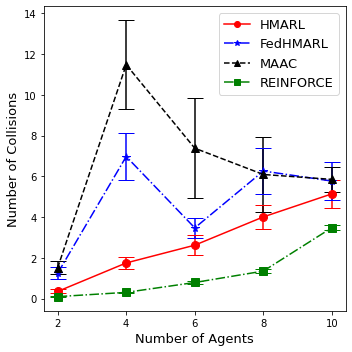

In [798]:
plt.figure(figsize=(5, 5))
n_agents = [2, 4, 6, 8, 10]
means_hac = np.asarray([m_hac2, m_hac4, m_hac6, m_hac8, m_hac10])
ups_hac = np.asarray([u_hac2, u_hac4, u_hac6, u_hac8, u_hac10])
means_fedhac = np.asarray([m_fedhac2, m_fedhac4, m_fedhac6, m_fedhac8, m_fedhac10])
ups_fedhac = np.asarray([u_fedhac2, u_fedhac4, u_fedhac6, u_fedhac8, u_fedhac10])
means_maac = np.asarray([m_maac2, m_maac4, m_maac6, m_maac8, m_maac10])
ups_maac = np.asarray([u_maac2, u_maac4, u_maac6, u_maac8, u_maac10])
means_RE = np.asarray([m_RE2, m_RE4, m_RE6, m_RE8, m_RE10])
ups_RE = np.asarray([u_RE2, u_RE4, u_RE6, u_RE8, u_RE10])

plt.errorbar(n_agents, means_hac, ups_hac - means_hac, color='red', capsize=8,
             linestyle='-', marker='o', markersize=8)
plt.errorbar(n_agents, means_fedhac, ups_fedhac - means_fedhac, color='blue', capsize=8,
             linestyle='-.', marker='*', markersize=8)
plt.errorbar(n_agents, means_maac, ups_maac - means_maac, color='black', capsize=8,
             linestyle='--', marker='^', markersize=8)
plt.errorbar(n_agents, means_RE, ups_RE - means_RE, color='green', capsize=8,
             linestyle='-.', marker='s', markersize=8)

legend_elements = [Line2D([0], [0], color='red', linestyle='-', marker='o', label='HMARL'),
                   Line2D([0], [0], color='blue', linestyle='-.', marker='*', label='FedHMARL'),
                   Line2D([0], [0], color='black', linestyle='--', marker='^', label='MAAC'),
                   Line2D([0], [0], color='green', linestyle='-.', marker='s', label='REINFORCE')]
plt.legend(handles=legend_elements, fontsize=13)
plt.xlabel('Number of Agents', fontsize=13)
plt.xticks(n_agents, n_agents)
plt.ylabel('Number of Collisions', fontsize=13)
plt.tight_layout()
plt.savefig("./results/figure/v2/collisions_vs_n_agents_v2.pdf", quality=95, dpi=300, bbox_inches='tight')